In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_68k_Zheng\Zheng_PBMC.h5ad")
adata.shape

(68579, 32738)

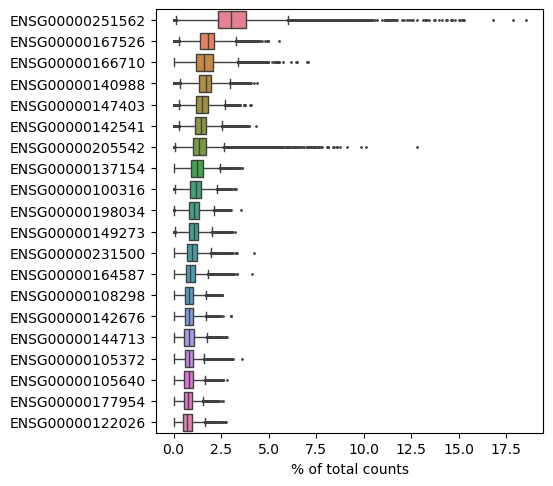

In [3]:
sc.pl.highest_expr_genes(adata, n_top=20)

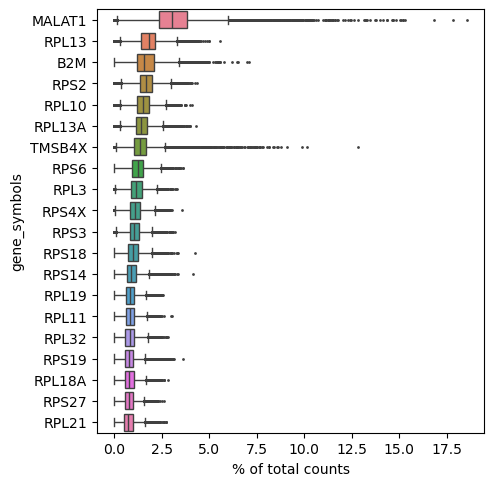

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbols')

## Quality control
(did not actually filter out cells)

In [ ]:
# Calculate quality control metrics
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var['gene_symbols'].str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             stripplot=False, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [ ]:
# filtering out the low quality cells
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## Normalization

In [5]:
# Normalization
# each observation (cell) has a total count equal to the median of total counts for observations (cells)
sc.pp.normalize_total(adata, target_sum=None)
# log1p transformation
sc.pp.log1p(adata)

In [ ]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression
# adata.raw = adata

## HVG

In [ ]:
# HVG2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var.highly_variable.sum()

In [ ]:
# filtering HVG2000
adata = adata[:, adata.var.highly_variable]
adata.shape

In [ ]:
# regress out the unwanted sources of variation
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# Scale each gene to unit variance
# sc.pp.scale(adata, max_value=10)

## PCA

In [6]:
sc.tl.pca(adata, svd_solver="arpack")

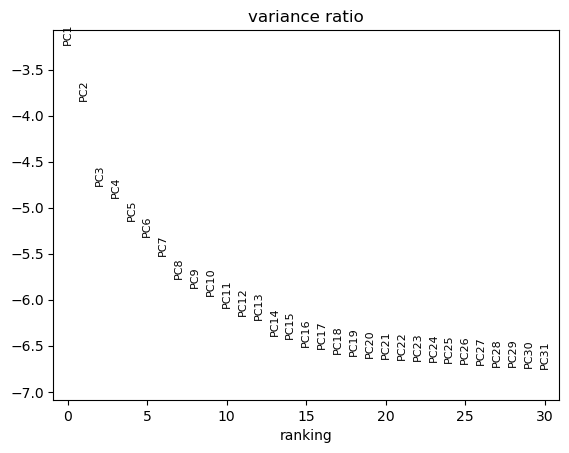

In [7]:
sc.pl.pca_variance_ratio(adata, log=True)

## UMAP

In [8]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, metric='jaccard')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
adata.obsp

PairwiseArrays with keys: distances, connectivities

In [10]:
sc.tl.umap(adata)

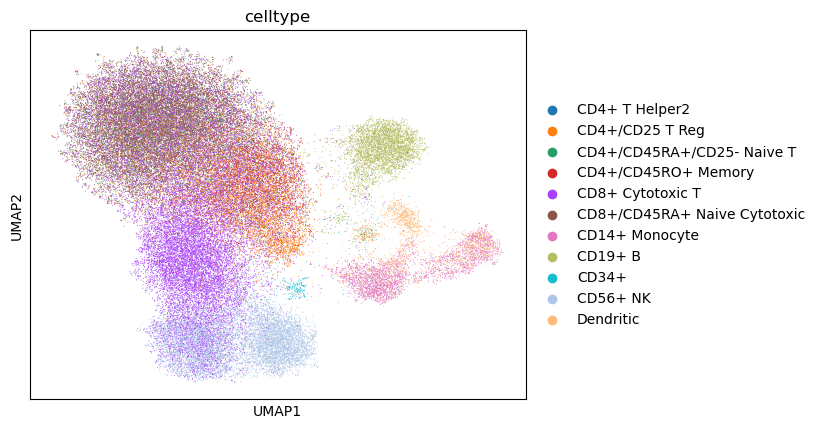

In [11]:
sc.pl.umap(adata, color='celltype')

## Leiden

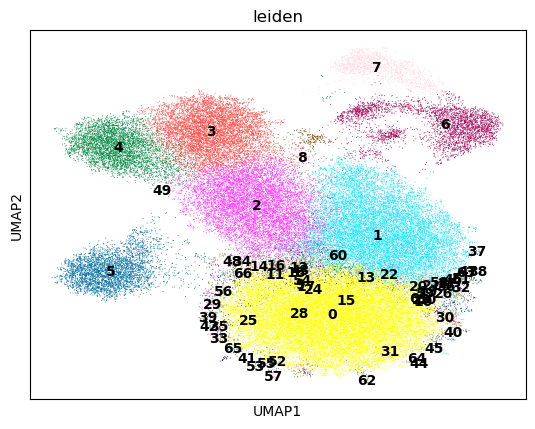

In [15]:
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color='leiden', legend_loc='on data')

In [ ]:
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='leiden', legend_loc='on data')
# sc.pl.umap(adata, color='celltype', legend_loc='right margin')

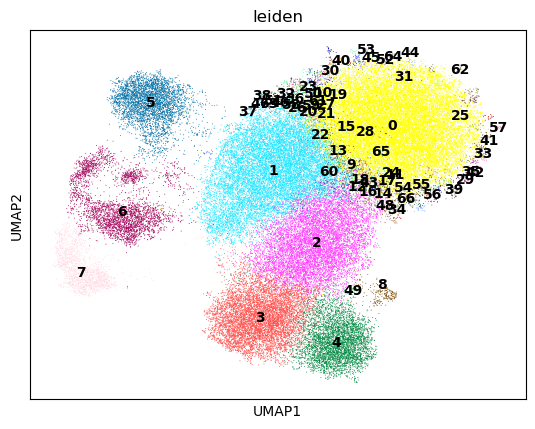

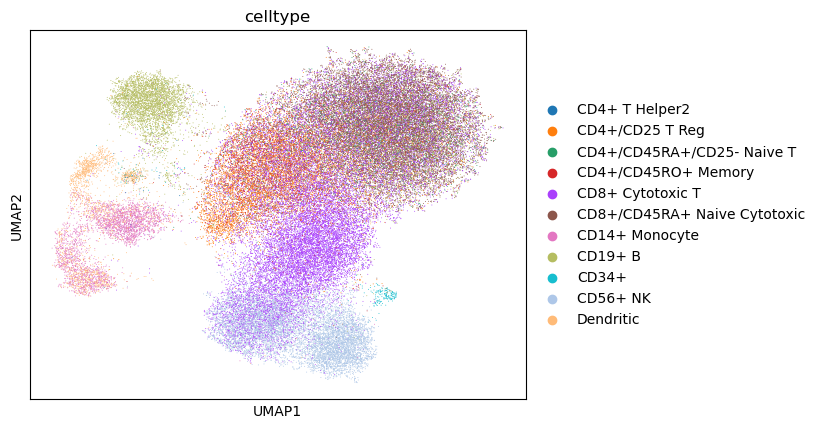

In [16]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color='leiden', legend_loc="on data")
sc.pl.umap(adata, color='celltype', legend_loc="right margin")

In [17]:
adata.obs['leiden'].unique()

['2', '0', '1', '5', '3', ..., '65', '30', '46', '63', '33']
Length: 67
Categories (67, object): ['0', '1', '2', '3', ..., '63', '64', '65', '66']

In [ ]:
adata.obs.head()

In [ ]:
cluster_names = []
for i in adata.obs['leiden'].tolist():
    cluster_names.append('Leiden_' + str(i))

adata.obs['leiden_cluster'] = cluster_names
adata.obs.head()


In [ ]:
adata.obs = adata.obs.drop('leiden', axis=1)
adata.obs.head()

In [ ]:
adata.obs['leiden_cluster'].value_counts()